In [11]:
import requests
from bs4 import BeautifulSoup
import urllib.parse
import copy
import itertools
import threading, time
import networkx as nx
import matplotlib.pyplot as plt


config_de = {"base": "https://de.wikipedia.org",
             "start_page": "https://de.wikipedia.org/wiki/Ernst-Th%C3%A4lmann-Park",
             "goal_page": "https://de.wikipedia.org/wiki/Kabinettsorder",
             "bad": ["/w/", "/Wikipedia", "/wiki/Hilfe", "/wiki/Spezial", "/wiki/Datei", "/wiki/Kategorie", 
                     "/wiki/Portal", "/wiki/Wikipedia:", "/wiki/Diskussion:"]}

config_en = {"base": "https://en.wikipedia.org",
             "start_page": "https://en.wikipedia.org/wiki/New_Horizons",
             "goal_page": "https://en.wikipedia.org/wiki/Silent_film",
             "bad": ["/w/", "/Wikipedia", "/wiki/Help", "/wiki/Special", "/wiki/File", "/wiki/Category", 
                     "/wiki/Portal", "/wiki/Wikipedia:", "/wiki/Discussion:"]}


# choose your config here:
config = config_de

base = config["base"]
bad = config["bad"]

In [12]:
def format_page(page):
    '''formats the page so it can be scraped. uses requests and BeautifulSoup libraries'''
    page_ready = BeautifulSoup(requests.get(page).text, "html.parser").body
    return page_ready


def prepare_bad_urls(base, bad):
    '''returns list of wikipedia subsites which shouldn't be used for the game'''
    full_bad_urls = []
    
    for bad_url in bad:
        full_bad_url = urllib.parse.urljoin(base, bad_url)
        full_bad_urls.append(full_bad_url)
    
    return full_bad_urls


def is_bad(full_bad_urls, url):
    '''determines whether a link is a "bad" link, i.e. should not be considered in the game'''
    for fbu in full_bad_urls:
        if url.startswith(fbu):
            return True
        
    return False
    

def clean(link):
    '''cleans linklist: removes external links and removes #'''
    full_url = urllib.parse.urljoin(base, link['href'])
        
    if "#" in full_url:
        full_url = full_url[:full_url.find("#")]
        
    if full_url == base:
        return "bad"
        
    if not full_url.startswith(base):
        return "bad"
    
    return full_url


def return_wiki_links(page):
    '''returns list of wiki links contained in a page.'''
    page_text = format_page(page)
    links_in_page = list(set(page_text.find_all('a', href=True)))
    
    wiki_links_in_page = [clean(link) for link in links_in_page]
    
    full_bad_urls = prepare_bad_urls(base, bad)
    wiki_links_in_page = [link for link in wiki_links_in_page if not is_bad(full_bad_urls, link)]
    
    return [link for link in wiki_links_in_page if link != "bad"]

In [13]:
class StoppableThread(threading.Thread):
    '''necessary edit of threading.Thread: progress thread needs to be 
    stopped once the goal page has been found'''
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._stop_event = threading.Event()
    
    def stop(self):
        self._stop_event.set()

    def stopped(self):
        return self._stop_event.is_set()

class ProgressMeter(StoppableThread):
    '''implements status info (number of links searched) that stops once the goal page is found.
    .stop() must be called at the moment the goal page is found'''
    def run(self):
        
        time.sleep(30)
        total_secs = 30
        
        while not self.stopped():
            print("Stay tuned - {} links searched, none matched the goal page so far...".format(len(already_tried)))
            time.sleep(30)
            total_secs += 30
        
        print("In total, {} links were searched in {} minutes.".format(len(already_tried), round(total_secs / 60, 1)))

In [14]:
def wikipedia_game(start_page, goal_page):
    
    urllen = len("{}/wiki/".format(base))
    G.add_node(start_page[urllen:])
    
    if goal_page == start_page:
        print("DONE: no need for searching a connection, the two pages are identical.")
        return print("You are already on {}".format(goal_page))

    round_count = 1
    
    progressthread = ProgressMeter()
    progressthread.start()
    
    links_to_test = return_wiki_links(start_page)
    [G.add_edge(start_page[urllen:], link[urllen:]) for link in links_to_test]
    
    print("LET'S GO: Starting to search the shortest connection between {} and {}".format(start_page, goal_page))
    
    parent_page = start_page # important for drawing...?

    while True:
        
        if round_count > 1:
            links_to_test = copy.deepcopy(new_links)
        else:
            new_links = []
        
        if goal_page in links_to_test:
            G.add_edge(goal_page[urllen:], start_page[urllen:])
            return print("DONE: The goal page {} can be reached with one click: {} is a link in {}.".format(goal_page, goal_page, goal_page))
        else:
            print("Round {} completed without results. Starting round {}.".format(round_count, (round_count + 1)))
            round_count += 1

            
        for link in links_to_test: #creates list with all links relevant for the round.
            
            parent_page = link
            
            new_links_bunch = [x for x in return_wiki_links(link) if x not in already_tried]
            
            if goal_page in new_links_bunch:
                G.add_edge(goal_page[urllen:], parent_page[urllen:])
                progressthread.stop()
                return print("DONE: The goal page can be reached with {} clicks: {} connects {} with {}.".format(str(round_count), link, start_page, goal_page, len(already_tried + new_links_bunch)))
            
            new_links.append(new_links_bunch)
            
            [already_tried.append(link) for link in new_links_bunch]
            [G.add_edge(parent_page[urllen:], link[urllen:]) for link in new_links_bunch]

        new_links = list(set(list(itertools.chain.from_iterable(new_links))))

LET'S GO: Starting to search the shortest connection between https://de.wikipedia.org/wiki/Ernst-Th%C3%A4lmann-Park and https://de.wikipedia.org/wiki/Kabinettsorder
Round 1 completed without results. Starting round 2.
DONE: The goal page can be reached with 2 clicks: https://de.wikipedia.org/wiki/Berliner_Stadtreinigung connects https://de.wikipedia.org/wiki/Ernst-Th%C3%A4lmann-Park with https://de.wikipedia.org/wiki/Kabinettsorder.
In total, 2383 links were searched in 0.5 minutes.


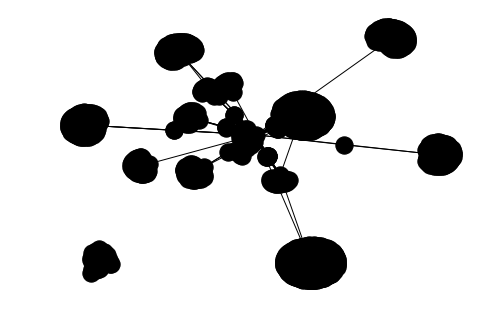

In [17]:
# now play the game:
already_tried = [config["start_page"]]

G=nx.karate_club_graph()

wikipedia_game(config["start_page"], config["goal_page"])

urllen = len("{}/wiki/".format(base))

pos = nx.spring_layout(G)
nx.draw(G,pos,node_color='k')

#nx.draw(G, with_labels = True, node_size = 2500, font_size = 8) 
#plt.savefig("path.pdf")

In [16]:
def show_path(Graph):
    '''prints a list of the path from start to goal!'''
    return [path for path in nx.all_simple_paths(Graph, source=config["start_page"][urllen:], 
                target=config["goal_page"][urllen:])]

show_path(G)

[['Ernst-Th%C3%A4lmann-Park', 'Berliner_Stadtreinigung', 'Kabinettsorder']]